# Brazilian E-Commerce Website: Olist Store

This project analyzes a Brazilian ecommerce public dataset of orders made at Olist Store.
This dataset contains information over 100,000 orders on the website between 2016-2018. The names of the suppliers have been anonymized.
Each order contains information such as: delivery status, price, size, customer location, and customer reviews.

In this project we are trying to find out how many orders made on this website arrive on time and if there is a correlation with seller reviews. We will also look at how the customer reviews are distributed. Perhaps late orders go hand in hand with bad reviews?

<b>Project overview</b>:
<ul>
    <li>Loading and cleaning the data files</li>
    <li><b>Question 1:</b> What is the average waiting time per seller?</li>
    <li><b>Question 2:</b> What is the percentage of late orders per seller?</li>
    <li><b>Question 2:</b> What is the correlation between delivery delay and seller review?</li>
    <li><b>Question 3:</b> How are the customer reviews distributed?</li>
</ul>

In [50]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## 1. Loading and cleaning the data files

The datasets are imported and the product category names are translated to English.

In [51]:
customers = pd.read_csv("olist_customers_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
name_translation = pd.read_csv("product_category_name_translation.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

In [52]:
product_category_name = name_translation["product_category_name"]
product_category_name_english = name_translation["product_category_name_english"]

translations = dict(zip(product_category_name, product_category_name_english))
translations.update({'portateis_cozinha_e_preparadores_de_alimentos': 'portable_kitchen_food_preparers', 'pc_gamer': 'pc_gamer'})

products["product_category_name"] = products["product_category_name"].map(translations)
print(products["product_category_name"])

0                        perfumery
1                              art
2                   sports_leisure
3                             baby
4                       housewares
                   ...            
32946              furniture_decor
32947    construction_tools_lights
32948               bed_bath_table
32949        computers_accessories
32950               bed_bath_table
Name: product_category_name, Length: 32951, dtype: object


<b>Merging files</b>

The files <b>order_items</b> and <b>orders</b> will be merged so that we have one dataset of the sellers, their sold items, the expected and actual delivery time, and the missing values will be erased.

In [77]:
merged_orders = pd.merge(left = order_items, right = orders, on = 'order_id').drop(['order_item_id','shipping_limit_date', 'order_purchase_timestamp', 'price', 'freight_value'], axis=1)
print(len(merged_orders))
merged_orders.head()

112650


,order_id,product_id,seller_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00


<b>Missing values</b>

A descriptive analysis is made of the difference between the delivered customer date and the estimated delivery time. To make an accurate analysis, we need to get rid of any missing values from the delivered customer dates. Let's check what the categories are of the missing values of the column order status.

In [80]:
nan = merged_orders[merged_orders["order_delivered_customer_date"].isna()]
nan["order_status"].unique()

array(['shipped', 'canceled', 'invoiced', 'processing', 'delivered',
       'approved', 'unavailable'], dtype=object)

It makes sense that there are NA-values in the column order_delivered_customer_date, because most of these are orders that have either been canceled or are still being processed. We will delete the NA-values in the column order_delivered_customer_date.

In [108]:
merged_orders = merged_orders[merged_orders["order_delivered_customer_date"].notna()]
print(len(merged_orders))
merged_orders.head()

110196


,order_id,product_id,seller_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,wait_time,on_time
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,-9,0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,-3,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,-14,0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,-6,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,-16,0


<b>Additional columns: waiting_time and on_time</b>

A new column called wait_time is created that shows the difference between the estimated and the actual delivery time, so we can see which sellers deliver their orders later than promised and which sellers deliver their products on time. Additionally, a boolean column called on_time will be created to see if the order was on time or not.

In [90]:
time_columns = ['order_delivered_customer_date',
                 'order_estimated_delivery_date']

for column in time_columns:
    merged_orders.loc[:, column] = pd.to_datetime(merged_orders[column]).copy()

merged_orders.loc[:,"wait_time"] = (merged_orders['order_delivered_customer_date'] - merged_orders['order_estimated_delivery_date']).dt.days
merged_orders['on_time'] = merged_orders["wait_time"] <= 0

merged_orders.head(3)

,order_id,product_id,seller_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,wait_time,on_time
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,-9,True
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,-3,True
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,-14,True


## Question 1: What is the average waiting time per seller?

All the orders in the dataset are grouped by their seller id, so it can be calculated what the mean waiting time per seller is.

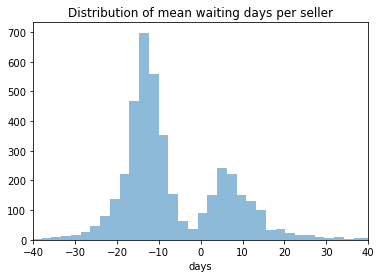

In [97]:
grouped_sellers = merged_orders.groupby(['seller_id', 'on_time'])["wait_time"].mean().sort_values()

kwargs = dict(histtype = 'stepfilled', alpha = 0.5, bins = 100)
plt.hist(grouped_sellers, label='waiting time', **kwargs)
plt.title("Distribution of mean waiting days per seller")
plt.xlabel("days")
plt.xlim((-40, 40))
plt.show()

<b>Findings:</b>

In the above graphs we can see that the distribution of waiting days are skewed to the right, with two peaks. The majority of the buyers receive their order sooner than the promised time.
Furthermore, there is also a group of sellers' that have their orders arriving not later than 10 days, but sellers whose packages arrive later than 15 days on average are very rare.

## Question 2: What is the percentage of late orders per seller?

Now that we know what average waiting time per seller is, we are also interested to know: what percentage of orders per seller are later than promised as opposed to the total of their orders? To find out what the answer is to this question, we calculate the total amount of orders per seller that were on time and divide it by their total amount of orders.

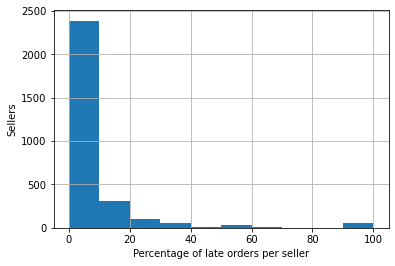

In [103]:
merged_orders['on_time'] = merged_orders['on_time'].map({True: 0, False: 1})
perc_lateorders = merged_orders.groupby(['seller_id'])['on_time'].apply(lambda x: x.sum() / x.count() *100)

perc_lateorders.hist()
plt.xlabel('Percentage of late orders per seller')
plt.ylabel('Sellers')
plt.show()

<b>Findings:</b><br>
In the above graph we can see that the percentage of late orders per seller are strongly skewed to the right. 
The majority of the sellers' orders have a maximum of 10% of their orders arriving late. There is also a smaller group of whom max 20% of their orders arrives late. A percentage higher than that is much less frequent.

## Question 3: What is the correlation between product arrival time and seller review?

We are curious to know if there is a correlation between orders arriving on time and the reviews that consumer give to the sellers. In order to answer this question, we need to merge the reviews dataset with merged_orders dataset.

In [104]:
merged_reviews = pd.merge(left = reviews, right = merged_orders, on = 'order_id').drop(['review_creation_date', 'review_answer_timestamp'], axis=1)
merged_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,product_id,seller_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,wait_time,on_time
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02,-16,0
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02,-16,0
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14,-5,0


The correlation between review score is calculated and plotted with a scatterplot.

In [66]:
print(merged_reviews['review_score'].corr(merged_reviews['wait_time']))

-0.2290298788540932


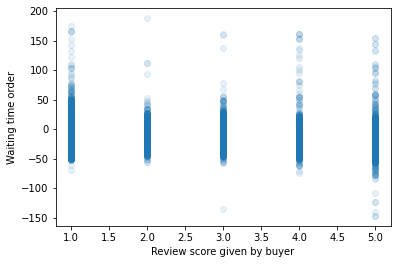

In [106]:
plt.scatter(x= merged_reviews['review_score'], y=merged_reviews['wait_time'], alpha=0.1)
plt.xlabel('Review score given by buyer')
plt.ylabel('Waiting time order')
plt.show()

<b>Findings:</b>
There is a negative, but not very strong correlation between given reviews and the waiting time. A shorter waiting time does not necessarily go hand in hand with a better review, as would be expected. This result can be due to the fact that we deleted all null values before in the column order status and with that deleted all orders from the dataset that were canceled or unavailable. We kept only the delivered orders and because of that, their reviews might be higher. We can dive a little bit further into the reviews to see what it tells us.

In [109]:
merged_reviews.groupby('order_status')['order_status'].count()

order_status
canceled          7
delivered    110005
Name: order_status, dtype: int64

## 4. Question 4: How are the customer reviews distributed?

text

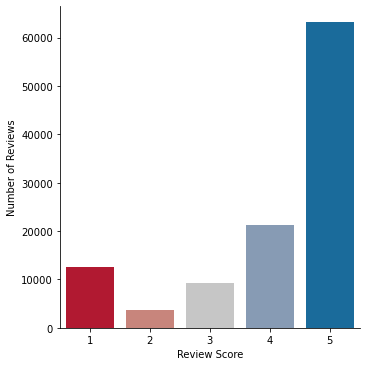

In [68]:
 sns.catplot(
    x='review_score', 
    kind='count', 
    data=merged_reviews, 
    palette=sns.color_palette(('#ca0020', '#d57b6f', '#c6c6c6', '#7f9abc', '#0571b0'))
).set(
    xlabel='Review Score', 
    ylabel='Number of Reviews',
);

<b>Conclusion:</b><br>
In this graph we can see that most customers give quite positive ratings (4 or 5 stars). However, there is also a group, the third biggest group, that gives a rating of 1 star. We don't know how happy customers are who don't give a rating. Perhaps happy customers are more likely to give a positive rating, but we cannot conclude that from this dataset. On the overall, we can conclude from this dataset that the customers who give reviews, give mostly positive review of 4 or 5 out of 5 stars, and the majority of the orders from the Olist Store arrives on time.